# 2. Propiedades estadísticas del lenguaje

## Práctica 2: Propiedades estadísticas de la lengua

### Fecha de entrega: 2 de Marzo de 2025 11:59pm

### ***Bibliotecas***

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from datasets import load_dataset
from spacy import displacy

/home/uciencias/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ***Ejercicio 1***

1. Verificar si la ley de Zipf se cumple en un lenguaje artificial creado por ustedes.
    - *Ejemplo:* Un "lenguaje artificial" podría ser simplemente un texto donde las secuencias de caracteres fueron generadas aleatoriamente.

In [2]:
def generate_random_language(
    num_words: int = 10_000,
    min_length: int = 3,
    max_length: int = 8,
    consonants: list[str] = ['b','c','d','f','g','h','k','m','n','p',
                              'r','s','t','v','z'],
    vocals: list[str] = ['a','e','i','o','u'],
    seed: int | None = None
) -> list[str]:
    """
    Genera un corpus de palabras aleatorias con una estructura silábica.

    Parámetros
    ----------
    num_words : int, opcional
        Número de palabras a generar.
    min_length : int, opcional
        Longitud mínima de las palabras generadas.
    max_length : int, opcional
        Longitud máxima de las palabras generadas.
    consonants : list de str, opcional
        Lista de consonantes para formar las palabras.
    vocals : list de str, opcional
        Lista de vocales para formar las palabras.
    seed : int o None, opcional
        Semilla para la generación aleatoria.

    Retorna
    -------
    list de str
        Lista de palabras generadas aleatoriamente.
    """
    np.random.seed(seed)

    min_syllables = max(1, min_length // 2)
    max_syllables = max(1, max_length // 2)

    syllables_per_word = np.random.randint(min_syllables, max_syllables + 1, num_words)

    corpus = []
    for num_syllables  in syllables_per_word:
        cons = np.random.choice(consonants, num_syllables)
        voc = np.random.choice(vocals, num_syllables)
        palabra = ''.join([c + v for c, v in zip(cons, voc)])
        corpus.append(palabra)

    return corpus

In [3]:
def analise_zipf(corpus: list[str],
                 graficar: bool = True) -> None:
    """
    Analiza la distribución de frecuencias y verifica la ley de Zipf.

    Parámetros
    ----------
    corpus : lista de str
        Lista de palabras sobre las que se realiza el análisis.
    graficar : bool, opcional
        Si es True, genera los gráficos correspondientes (por defecto True).

    Retorna
    -------
    None
    """
    frequencies = Counter(corpus)
    corpus_freqs = pd.DataFrame(list(frequencies.items()),
                                columns=['word', 'freq'])
    corpus_freqs = corpus_freqs.sort_values(by='freq',
                                            ascending=False).reset_index(drop=True)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4
                                            ))

    corpus_freqs["freq"].plot(marker="o", ax=axes[0])
    axes[0].set_title('Ley de Zipf en lenguaje artificial aleatorio')
    axes[0].set_xlabel('rank')
    axes[0].set_ylabel('freq')

    corpus_freqs['freq'].plot(loglog=True, ax=axes[1], legend=False)
    axes[1].set_title('Ley de Zipf en lenguaje artificial aleatorio (log-log)')
    axes[1].set_xlabel('log rank')
    axes[1].set_ylabel('log frecuencia')

    names, frequencies = zip(*Counter(corpus).most_common(13))
    axes[2].bar(names, frequencies)
    axes[2].set_title('Histograma de Frecuencias de las 13 palabras más comunes')
    axes[2].set_xlabel('Palabra')
    axes[2].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

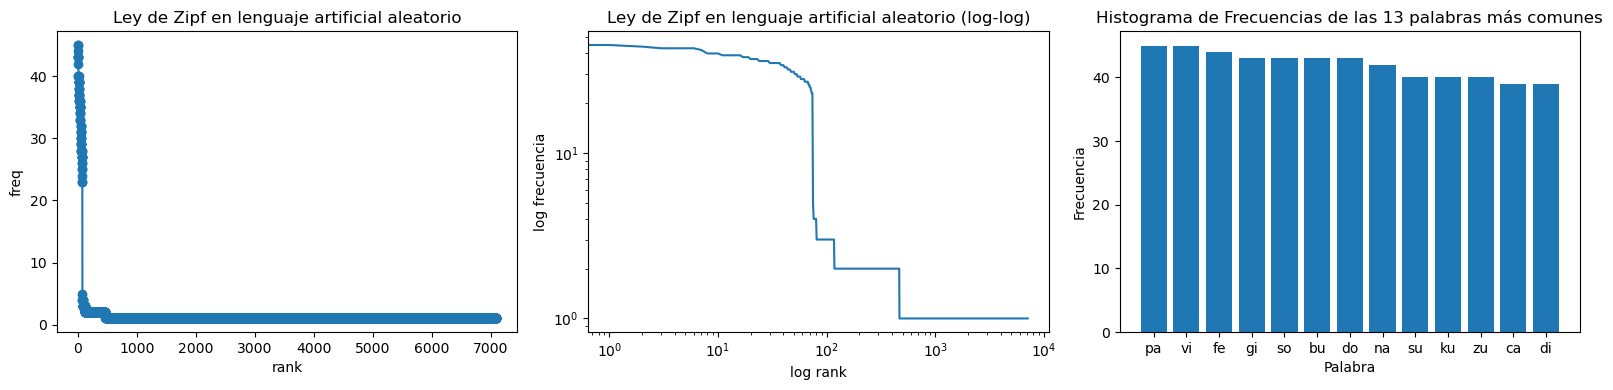

In [4]:
analise_zipf(generate_random_language(seed=29))

#### 🔍 ***Conclusión***

El análisis del lenguaje artificial generado muestra que su distribución de palabras no sigue la ley de Zipf, lo que se refleja claramente en los gráficos. En la primera gráfica de frecuencias ordenadas, podemos ver que la mayoría de las palabras tienen frecuencias muy similares, sin una diferencia marcada entre las más y menos comunes. En un lenguaje natural, en cambio, esperaríamos una caída más gradual, donde unas pocas palabras sean dominantes y muchas otras aparezcan solo ocasionalmente.

La segunda gráfica, en escala log-log, confirma esta diferencia de manera más evidente. En los idiomas naturales, la distribución sigue una línea recta con pendiente negativa en este tipo de gráfico, lo que indica una relación de ley de potencia. Sin embargo, en el lenguaje artificial, la curva cae abruptamente y luego se aplana, mostrando que las frecuencias no siguen la estructura jerárquica esperada en un idioma humano.

Este resultado demuestra que la ley de Zipf no surge simplemente por azar en cualquier conjunto de palabras, sino que es una consecuencia del uso y la evolución del lenguaje en contextos sociales y comunicativos. Sin un mecanismo que favorezca la repetición de ciertas palabras sobre otras, la distribución de frecuencias resulta más uniforme y no presenta la misma organización estadística que los idiomas reales.

### ***Ejercicio 2***

2. Explorar `datasets` del sitio [Hugging Face](https://huggingface.co/datasets) y elegir documentos de diferentes dominios en Español (al menos 3). Realizar reconocimiento de entidades nombradas (NER).
    - Pueden utilizar subconjuntos de los datasets encontrados
    - Mostrar resultados del reconocimiento
    - Una distribución de frecuencias de las etiquetas más comunes en cada dominio
    - Comentarios generales del desempeño observado.

*Sugerencias: Spacy, CoreNLP (puede ser cualquier otra herramienta)*

In [5]:
def process_ner(texts: list, domain: str, sample_size: int = 100) -> None:
    """
    Procesa un conjunto de textos para análisis de entidades (NER) y muestra
    la distribución de entidades y ejemplos visuales.

    Parámetros
    ----------
    texts : lista de str
        Lista de textos para procesar con el modelo NER.
    domain : str
        Nombre del dominio o tema relacionado con los textos, usado en el
        título de la visualización.
    sample_size : int, opcional
        Número de textos a muestrear para el análisis (por defecto 100).

    """
    np.random.seed(42)

    indices = np.random.choice(len(texts), size=sample_size, replace=False)
    sample_texts = [str(texts[i]) for i in indices]

    docs = list(nlp.pipe(sample_texts))

    labels = [ent.label_ for doc in docs for ent in doc.ents]
    label_counts = Counter(labels)

    plt.figure(figsize=(10, 4))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.title(f"Distribución de Entidades - {domain}")
    plt.xticks(rotation=45)
    plt.show()

    print(f"\n🔍 Ejemplos de análisis para {domain}:")
    displacy.render(docs[:3], style="ent")

In [6]:
# Cargar modelo español de Spacy
nlp = spacy.load("es_core_news_md")
# 1. Dataset: Quran en español (Versículos religiosos)
quran = load_dataset("nazimali/quran")

# 2 Dataset: Juridico Mexicano
juridico = load_dataset("Danielbrdz/Barcenas-Juridico-Mexicano-Dataset")

# 3 Dataset: Tweets de Gustavo Petro (presidente)
tweets = load_dataset("jhonparra18/petro-tweets")

Using the latest cached version of the dataset since nazimali/quran couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/uciencias/.cache/huggingface/datasets/nazimali___quran/default/0.0.0/e7070e8411006fc1b469dbf0f1f54d446e562d33 (last modified on Mon Mar  3 00:45:08 2025).
Using the latest cached version of the dataset since Danielbrdz/Barcenas-Juridico-Mexicano-Dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/uciencias/.cache/huggingface/datasets/Danielbrdz___barcenas-juridico-mexicano-dataset/default/0.0.0/78876b4d47157aa472ff43c9855d2d635de735b6 (last modified on Mon Mar  3 00:45:11 2025).


In [9]:
textos_quran = [i for i in quran["train"]["translation-es-garcia"]]
textos_juridico = [i for i in juridico["train"]["answer"]]
textos_tweets = [i for i in tweets["train"]["Tweet"]]

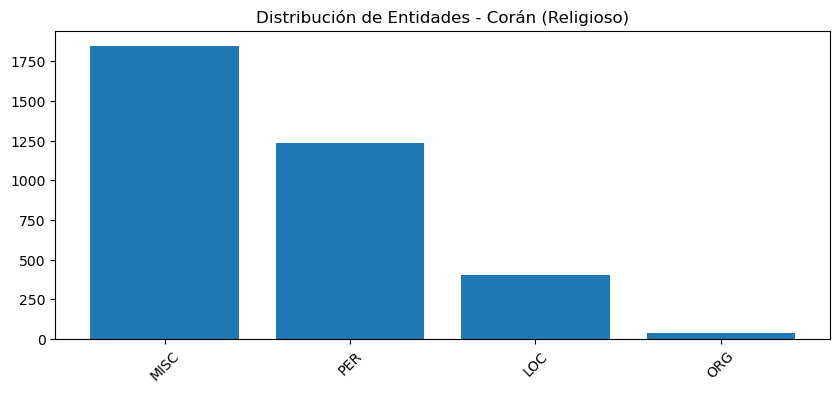


🔍 Ejemplos de análisis para Corán (Religioso):


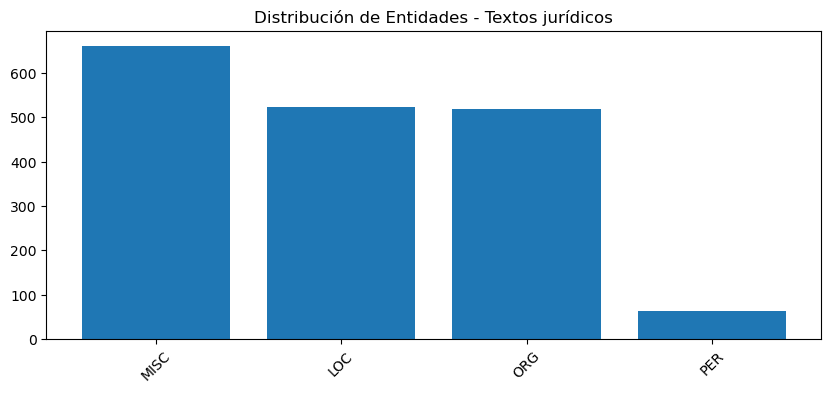


🔍 Ejemplos de análisis para Textos jurídicos:


/home/uciencias/anaconda3/envs/nlp/lib/python3.11/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


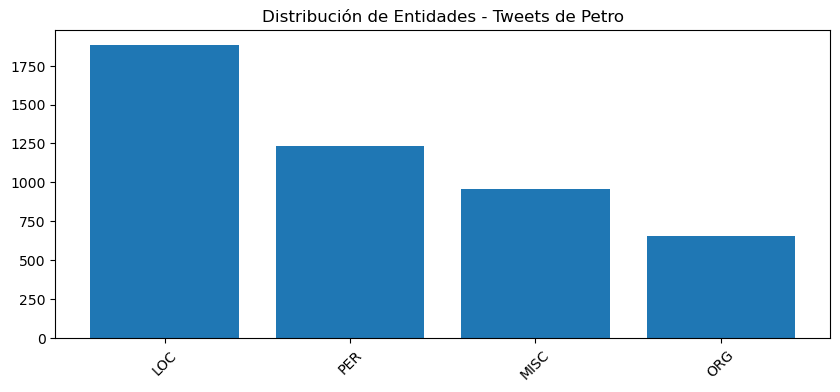


🔍 Ejemplos de análisis para Tweets de Petro:


In [8]:
process_ner(textos_quran, "Corán (Religioso)", sample_size=2_000)
process_ner(textos_juridico, "Textos jurídicos", sample_size=2_000)
process_ner(textos_tweets, "Tweets de Petro", sample_size=2_000)

#### 🔍 ***Conclusión***

En el dataset del corán, la predominancia de MISC y PER es esperable en un texto religioso, donde se mencionan conceptos teológicos y figuras clave más que lugares o instituciones específicas.

Por otro lado, los textos jurídicos tienen alta frecuencia de MISC y LOC sugiere que los textos jurídicos mencionan normativas y jurisdicciones más que individuos específicos, mientras que la presencia de ORG refuerza el enfoque institucional del contenido.

Por último, el datset de Petro tiene un alto número de LOC y PER indica que los tweets de Petro se centran en discursos sobre regiones y actores políticos, mientras que MISC refleja la inclusión de conceptos ideológicos o eventos relevantes en el debate político.

Cada dominio refleja su naturaleza a través de las entidades mencionadas, mostrando que textos religiosos se centran en personajes y conceptos, los jurídicos en normativas y jurisdicciones, y los tweets en discursos políticos con fuerte referencia a lugares y personas.